In [3]:
import skrf as rf
from skrf.constants import K_BOLTZMANN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.interpolate import interp1d
from devices.devices_lib import make_cavity__with_antennas_network # From Chirstan Boutan's PNNL team
import components as cmp # From Jihee

%matplotlib inline

No display found. Using non-interactive Agg backend.


In [10]:
freq = rf.frequency.Frequency(start=4, stop=6, npoints=1001, unit='ghz', sweep_type='lin')
Troom = 300
pow_to_dbm = lambda x: 10*np.log(x/1e-3)


In [11]:
###############################
##### Component Functions   ###
###############################
#(From Jihee's components.py and analyis_run1C_tsys.py)


### Function to read network in noisy environment ###
def read_in_noisy_network(ntw,freq_interp,Tphys):
    ntw_interp = ntw.interpolate(freq_interp, kind='cubic')
    ntw_interp_noisy = rf.NoisyNetwork(ntw_interp)
    ntw_interp_noisy.noise_source(source='passive',T0 = Tphys)

    return ntw_interp_noisy

### Function to make coaxial cable with coaxial line and SMA connector sample ###
def make_coax_cable(c_type,freq,len_m,Tphys):
        
    if c_type=='RG405U':
        ntw_coax_RT = cmp.cable_RG405U(freq,len_m)
        ntw_coax_cryo = cmp.RT2Cryo(ntw_coax_RT)
        # ntw_coax_cryo = ntw_coax_RT
        # ntw_SMA_RT = cmp.cable_RG405U(freq,0.04)
        ntw_SMA_RT = cmp.SMA_RG405U(freq,0.015)
        ntw_SMA_cryo = cmp.RT2Cryo(ntw_SMA_RT)
        # ntw_SMA_cryo = ntw_SMA_RT
    elif c_type=='PESR405FL':    
        ntw_coax_RT = cmp.cable_PESR405FL(freq,len_m)
        ntw_coax_cryo = cmp.RT2Cryo(ntw_coax_RT)
        # ntw_coax_cryo = ntw_coax_RT
        # ntw_SMA_RT = cmp.cable_PESR405FL(freq,0.04)
        ntw_SMA_RT = cmp.SMA_PESR405FL(freq,0.015)
        ntw_SMA_cryo = cmp.RT2Cryo(ntw_SMA_RT)
        # ntw_SMA_cryo = ntw_SMA_RT
    elif c_type=='NbTi085':
        ntw_coax_cryo = cmp.cable_NbTi085(freq,len_m)
        ntw_SMA_cryo = cmp.cable_NbTi085(freq,0.015)
    else:
        print('Error: Proper cable type is missing')

    noisy_ntw_coax = read_in_noisy_network(ntw_coax_cryo,freq,Tphys)
    noisy_ntw_SMA = read_in_noisy_network(ntw_SMA_cryo, freq, Tphys)
    
    assmb_cable = rf.MultiNoisyNetworkSystem()

    noisy_ntw_SMA.add_noise_polar(1e-6, 0.5)
    assmb_cable.add(noisy_ntw_SMA,'SMA1')
    assmb_cable.add(noisy_ntw_coax,'coax')
    noisy_ntw_SMA.add_noise_polar(1e-6, 0.55)
    assmb_cable.add(noisy_ntw_SMA,'SMA2')

    assmb_cable.connect('SMA1',2, 'coax',1)
    assmb_cable.connect('coax',2, 'SMA2',1)

    assmb_cable.external_port('SMA1',1,1)
    assmb_cable.external_port('SMA2',2,2)

    noisy_ntw_cable = assmb_cable.reduce()
    noisy_ntw_cable = read_in_noisy_network(noisy_ntw_cable,freq,Tphys)
        
    return noisy_ntw_cable  

In [6]:
def plot_Tsys_for_termi_temps(termi_temps):
    for termi_temp in termi_temps:
        ###############################
        ##### create components     ###
        ###############################


        #Cavity
        freq_cavity = 5e9
        R_cavity=1_000 # resistance 
        Q_cavity=2_000
        
        start_freq = 4e9
        stop_freq = 6e9

        ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity)
        noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, Troom)

        #Circulator
        ntw_circ1 = cmp.create_ideal_circulator2(freq)
        noisy_ntw_circ1 = read_in_noisy_network(ntw_circ1, freq, Troom)

        ntw_circ2 = cmp.create_ideal_circulator2(freq)
        noisy_ntw_circ2 = read_in_noisy_network(ntw_circ2, freq, Troom)

        #Terminator
        ntw_termi = cmp.create_terminator(freq,Gamma_0=0.048) # [[What determines gamma_0 here?]]
        noisy_ntw_termi = read_in_noisy_network(ntw_termi, freq, termi_temp) ## <------ function parameter

        #terminators for circulator termination of individual paths
        noisy_ntw_termi_2 = read_in_noisy_network(ntw_termi, freq, Troom)
        noisy_ntw_termi_3 = read_in_noisy_network(ntw_termi, freq, Troom)


        #Cables
        LEN_CABLE1 = 0.01 #m
        LEN_CABLE2 = 0.01 #m
        LEN_CABLE3 = 0.01 #m
        LEN_CABLE4 = 0.01 #m
        LEN_CABLE5 = 0.01 #m

        noisy_ntw_cable_1 = make_coax_cable('RG405U',freq,LEN_CABLE1,Troom)
        noisy_ntw_cable_2 = make_coax_cable('RG405U',freq,LEN_CABLE2,Troom)
        noisy_ntw_cable_3 = make_coax_cable('RG405U',freq,LEN_CABLE3,Troom)
        noisy_ntw_cable_4 = make_coax_cable('RG405U',freq,LEN_CABLE4,Troom)
        noisy_ntw_cable_5 = make_coax_cable('RG405U',freq,LEN_CABLE5,Troom)



        ###############################
        ##### Component assemnly    ###
        ###############################

        #Cavity -> JPA
        mnns_cav2JPA = rf.MultiNoisyNetworkSystem()

        mnns_cav2JPA.add(noisy_ntw_cav,'cavity')
        mnns_cav2JPA.add(noisy_ntw_cable_1,'cable1')
        mnns_cav2JPA.add(noisy_ntw_circ1,'circ1')     #circ1 is clockwise
        mnns_cav2JPA.add(noisy_ntw_cable_2,'cable2')
        mnns_cav2JPA.add(noisy_ntw_termi,'termi')
        mnns_cav2JPA.add(noisy_ntw_termi_2,'termi2')
        mnns_cav2JPA.add(noisy_ntw_cable_3,'cable3')
        mnns_cav2JPA.add(noisy_ntw_circ2,'circ2')
        mnns_cav2JPA.add(noisy_ntw_cable_4,'cable4')
        #mnns_cav2JPA.add(noisy_ntw_circ2,'circ2') #[[Not sure how to deal with JPA]]
        #mnns_cav2JPA.add(noisy_ntw_cable_4,'cable4')

        ## diagram of cav -> JPA

        # (in) - 2-[Cavity]-1 <-> 2-[cable1]-1 <-> 3-(circ1)-1 <-> 2-[cable3]-1 <-> 1-(circ2)-3 -_termi_
        #                                              2                               2
        #                                              2                               2
        #                                          [cable2]                        [cable4]          
        #                                              1                              1                           
        #                                           _termi_                         (out)
        
        
                             


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns_cav2JPA.connect('cavity',1,'cable1',2)
        mnns_cav2JPA.connect('cable1',1,'circ1',3)
        mnns_cav2JPA.connect('circ1',2,'cable2',1)
        mnns_cav2JPA.connect('cable2',2,'termi',1)
        mnns_cav2JPA.connect('circ1',1,'cable3',2)
        mnns_cav2JPA.connect('cable3',1,'circ2',1)
        mnns_cav2JPA.connect('circ2',2,'cable4',1)
        mnns_cav2JPA.connect('circ2',3,'termi2',1)


        mnns_cav2JPA.external_port('cavity',2,1)
        mnns_cav2JPA.external_port('cable4',2,2)

        assem_cav2JPA = mnns_cav2JPA.reduce()

        ## JPA -> SA
        
        # _termi_- 1-(circ2)-3 - 2-[cable5]-1 - out
        #              2
        #              2
        #           [cable4]
        #              1
        #            (JPA)

        mnns_JPA2SA = rf.MultiNoisyNetworkSystem()

        mnns_JPA2SA.add(noisy_ntw_cable_4,'cable4')
        mnns_JPA2SA.add(noisy_ntw_circ2,'circ2')   # circ2 is counterclockwise
        mnns_JPA2SA.add(noisy_ntw_termi_3,'termi3')
        mnns_JPA2SA.add(noisy_ntw_cable_5,'cable5')

        mnns_JPA2SA.connect('cable4',2,'circ2',2)
        mnns_JPA2SA.connect('termi3',1,'circ2',1)
        mnns_JPA2SA.connect('cable5',2,'circ2',3)


        mnns_JPA2SA.external_port('cable5',1,2)
        mnns_JPA2SA.external_port('cable4',1,1)

        assem_JPA2SA = mnns_JPA2SA.reduce()


        ###############################
        ##### Noise Temp extraction ###
        ###############################

        # Find Noise Temp along path to amplifier: (From Garcia-Garcia paper eqn 18)
        A = np.array([[1, 0],[0,0]]) 
        AS  = np.matmul(A,np.conjugate(np.swapaxes(assem_cav2JPA.s,1,2)))
        SAS = np.matmul(assem_cav2JPA.s,AS)
        T_n_cav2JPA  = (1/(K_BOLTZMANN))*assem_cav2JPA.cs[:,1,1]/SAS[:,1,1]

        # Find Noise Temp from amplifier to analyzer:
        A = np.array([[1, 0],[0,0]])
        AS  = np.matmul(A,np.conjugate(np.swapaxes(assem_JPA2SA.s,1,2)))
        SAS = np.matmul(assem_JPA2SA.s,AS)
        T_n_JPA2SA  = (1/(K_BOLTZMANN))*assem_JPA2SA.cs[:,1,1]/SAS[:,1,1]
        T_n_JPA2SA  = (1/(K_BOLTZMANN))*assem_JPA2SA.cs[:,1,1]/SAS[:,1,1]

        # Noise Temp of JPA:
        g_jpa = 10**(18/10) #18 dB gain
        T_n_JPA = 2*rf.NetworkNoiseCov.Tnoise(freq.f,Troom) 
        g_cav2JPA = abs(assem_cav2JPA.s[:,1,0])

        # Noise of path 1 + amplifier + path 2: (from Friis formula) 
        T_n_rx = T_n_cav2JPA + (T_n_JPA/g_cav2JPA) + (T_n_JPA2SA)/(g_cav2JPA*g_jpa) 

        #Total Noise temp
        T_cav = rf.NetworkNoiseCov.Tnoise(freq.f,Troom)
        T_n_sys = T_cav + T_n_rx


        ## Plotting

        plt.plot(freq.f/1e9 , T_n_sys,label=f'{termi_temp}K')
        plt.xlabel('Frequency [GHz]')
        plt.ylabel('Noise Temperature [K]')
        plt.title(f'System Noise Temperature')
        plt.legend()
        plt.tight_layout(pad=0.3, w_pad=0.2, h_pad=0.2)

In [18]:
### Plotting Cs matrix for cavity to second circulator
def plot_cs_cav2circ2_for_termi_temps(termi_temps):
    
    for termi_temp in termi_temps:
        
        #Cavity
        freq_cavity = 5e9
        R_cavity=1_000 # resistance 
        Q_cavity=2_000

        start_freq = 4e9
        stop_freq = 6e9

        ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity) # [[What are the N's here?]]
        noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, Troom)

        #Circulator
        ntw_circ1 = cmp.create_ideal_circulator2(freq)
        noisy_ntw_circ1 = read_in_noisy_network(ntw_circ1, freq, Troom)


        #Terminator
        ntw_termi = cmp.create_terminator(freq,Gamma_0=0.048) # [[What determines gamma_0 here?]]
        noisy_ntw_termi = read_in_noisy_network(ntw_termi, freq, termi_temp) ## <------ function parameter


        #Cables
        LEN_CABLE1 = 0.01 #m
        LEN_CABLE2 = 0.01 #m
        LEN_CABLE3 = 0.01 #m

        noisy_ntw_cable_1 = make_coax_cable('RG405U',freq,LEN_CABLE1,Troom)
        noisy_ntw_cable_2 = make_coax_cable('RG405U',freq,LEN_CABLE2,Troom)
        noisy_ntw_cable_3 = make_coax_cable('RG405U',freq,LEN_CABLE3,Troom)

        # Circuit diagram
        
        # (in) - 2-[Cavity]-1 <-> 2-[cable1]-1 <-> 3-(circ1)-1 <-> 2-[cable3]-1 - out
        #                                              2                               
        #                                              1                               
        #                                           [cable2]                          
        #                                              2                                                
        #                                           _termi_   
        
        
        # Cavity -> Second Circulator

        mnns_cav2circ2 = rf.MultiNoisyNetworkSystem()

        mnns_cav2circ2.add(noisy_ntw_cav,'cavity')
        mnns_cav2circ2.add(noisy_ntw_cable_1,'cable1')
        mnns_cav2circ2.add(noisy_ntw_circ1,'circ1') #clockwise
        mnns_cav2circ2.add(noisy_ntw_cable_2,'cable2')
        mnns_cav2circ2.add(noisy_ntw_termi,'termi')
        mnns_cav2circ2.add(noisy_ntw_cable_3,'cable3')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns_cav2circ2.connect('cavity',1,'cable1',2)
        mnns_cav2circ2.connect('cable1',1,'circ1',3)
        mnns_cav2circ2.connect('circ1',2,'cable2',1)
        mnns_cav2circ2.connect('cable2',2,'termi',1)
        mnns_cav2circ2.connect('circ1',1,'cable3',2)


        mnns_cav2circ2.external_port('cavity',2,1)
        mnns_cav2circ2.external_port('cable3',1,2)

        assem_cav2circ2 = mnns_cav2circ2.reduce()

        plt.plot(freq.f/1e9,pow_to_dbm(assem_cav2circ2.cs[:,1,1]),label=f'{termi_temp}K')
        plt.xlim(4.75,5.25)
        plt.xlabel('Frequency [GHz]')
        plt.ylabel('Noise Power per Hz [dBm/Hz]')
        plt.title(f' Cavity to Circ2 \n Noise Power spectral density')
        plt.legend()
        plt.tight_layout(pad=0.3, w_pad=0.2, h_pad=0.2)


/Users/zacharybanken/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/zacharybanken/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/zacharybanken/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


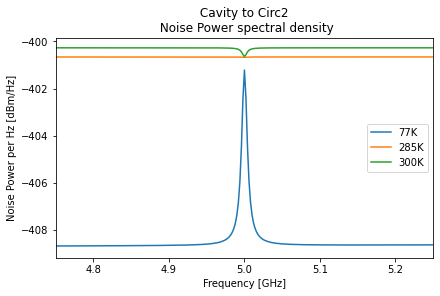

In [19]:
termi_temps = [77,285,300]
plot_cs_cav2circ2_for_termi_temps(termi_temps)

/Users/zacharybanken/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/zacharybanken/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/zacharybanken/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


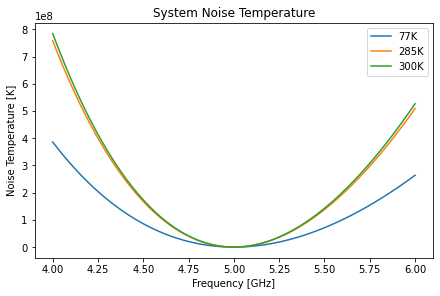

In [9]:
plot_Tsys_for_termi_temps(termi_temps)